# Training a Model
The purpose of this notebook is to train a lambeq model and then see how that model reacts to new data. The details of the aims are explained in **Entry 1** of [this journal page](/Journal/09_10_24.md). I will loosely be following [this example](https://cqcl.github.io/lambeq-docs/examples/quantum-pipeline.html) from lambeq's website.

In [1]:
### IMPORTS
import warnings
import os
from lambeq import BobcatParser, RemoveCupsRewriter, AtomicType, IQPAnsatz, TketModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import numpy as np
from pytket.extensions.qiskit import AerBackend

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

c:\Users\Luke\anaconda3\envs\QNLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We set up the training parameters as follows:

In [2]:
BATCH_SIZE = 30
EPOCHS = 120
SEED = 2

First, we read the input data.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])  # Either 0 or 1 depending on whether about food or IT
            labels.append([t, 1-t])  # Converting to 2D array
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('data/training_data.txt')
dev_labels, dev_data = read_data('data/dev_data.txt')

Next, we create DisCoCat diagrams from the training data by using the `BobcatParser` object from the `lambeq` package.

In [4]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


**(Optional)** We can display the raw diagrams.

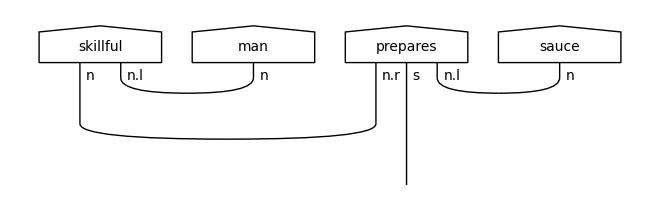

In [5]:
raw_train_diagrams[0].draw()

We now optimise the diagrams by removing the cups using the `RemoveCupsRewriter` object.

In [6]:
remove_cups = RemoveCupsRewriter()
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]

**(Optional)** We can display the new cupless diagrams.

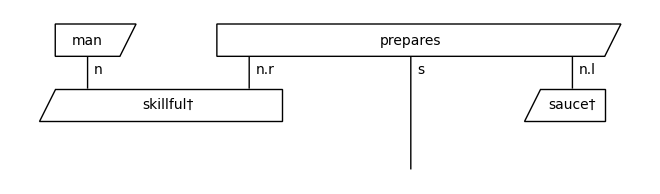

In [7]:
train_diagrams[0].draw()

We now utilise the `IQPAnsatz` object to create paramaterized quantum circuits for all the training sentences using the cupless diagrams we have generated.

In [8]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)  # Setting no. of qubits and qubit parameters
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]

**(Optional)** We can display the paramaterized quantum circuits we have created.

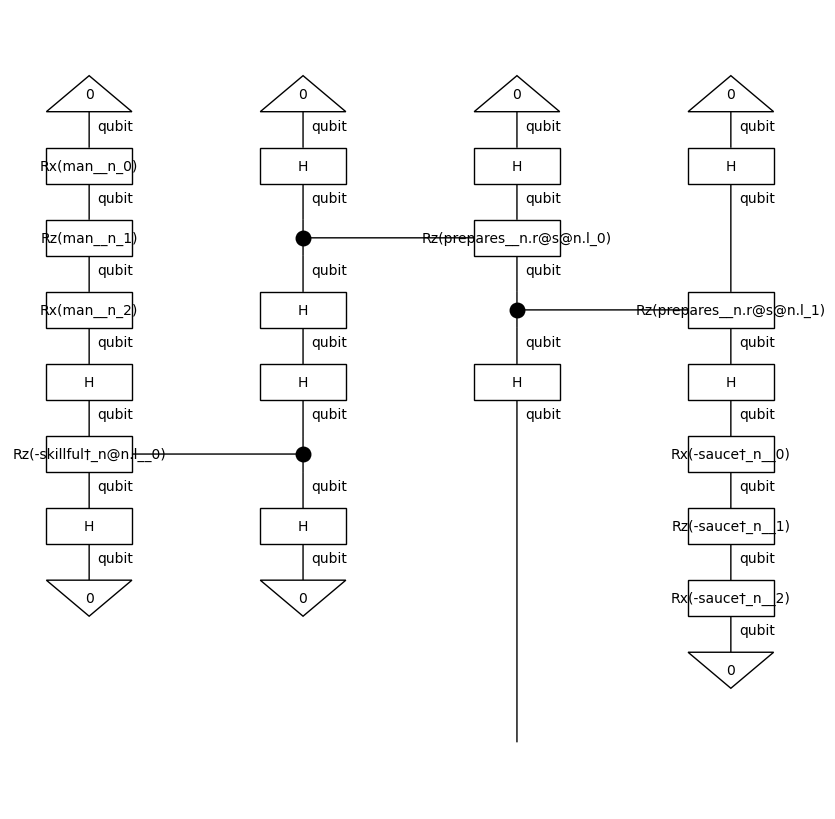

In [9]:
train_circuits[0].draw(figsize=(8,8))

Next, we initialize the trainer, specifying the backend to use, loss function and model. We use binary cross-entropy loss as our loss function as we are dealing with a *binary* categorization problem.

In [10]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 1024
}

all_circuits = train_circuits+dev_circuits
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

bce = BinaryCrossEntropyLoss()  # Loss function
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

Finally, we train the trainer using the training dataset and the validation dataset.

In [11]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [13]:
trainer.fit(train_dataset, val_dataset, log_interval=12)

Epoch 12:   train/loss: 0.5080   valid/loss: 0.7429   train/time: 2m45s   valid/time: 35.56s   train/acc: 0.6000   valid/acc: 0.6000
Epoch 24:   train/loss: 1.1015   valid/loss: 0.8014   train/time: 2m47s   valid/time: 36.27s   train/acc: 0.4714   valid/acc: 0.4000
Epoch 36:   train/loss: 0.5312   valid/loss: 0.6144   train/time: 2m45s   valid/time: 35.41s   train/acc: 0.5857   valid/acc: 0.6667
Epoch 48:   train/loss: 0.3513   valid/loss: 0.5297   train/time: 2m57s   valid/time: 38.81s   train/acc: 0.6429   valid/acc: 0.7333
Epoch 60:   train/loss: 0.5269   valid/loss: 0.5162   train/time: 2m49s   valid/time: 36.55s   train/acc: 0.7286   valid/acc: 0.7667
Epoch 72:   train/loss: 0.4241   valid/loss: 0.4475   train/time: 2m49s   valid/time: 37.19s   train/acc: 0.8286   valid/acc: 0.7667
Epoch 84:   train/loss: 0.4804   valid/loss: 0.3990   train/time: 2m49s   valid/time: 36.95s   train/acc: 0.9071   valid/acc: 0.8000
Epoch 96:   train/loss: 0.1963   valid/loss: 0.3946   train/time: 2m4

Now we have trained our model, we can use it.